In [33]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
import os
import sys
import copy
import time
import numpy as np
import tabulate
sys.path.append(os.path.join(os.path.abspath(""), ".."))

import matplotlib.pyplot as plt

In [35]:
from app.utils import ImageWrapper
from app.custom import RemoveBusBars, Orient, BusbarMask
from app.transforms import FFT, IFFT, CreateOnesMask, PCA, DownsampleBlur
from app.filters import CreateKernel, Convolve, Canny, HOG, Threshold_Multiotsu
from app.imager import ImageLoader, DefectViewer, Show, Exposure

from app.models import Classifier
from sklearn.linear_model import LogisticRegression

In [4]:
# Seed used in show to show the same images when num_images option is set
seed = 1234

# Utility function for plotting during this EDA:
def plot_10(in_imgs):
    fig, axs = plt.subplots(2,5, figsize=(15, 6))
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()
    for i in range(10):
        axs[i].imshow(in_imgs[i], cmap='Greys_r')
        axs[i].set_title(f'{i}')

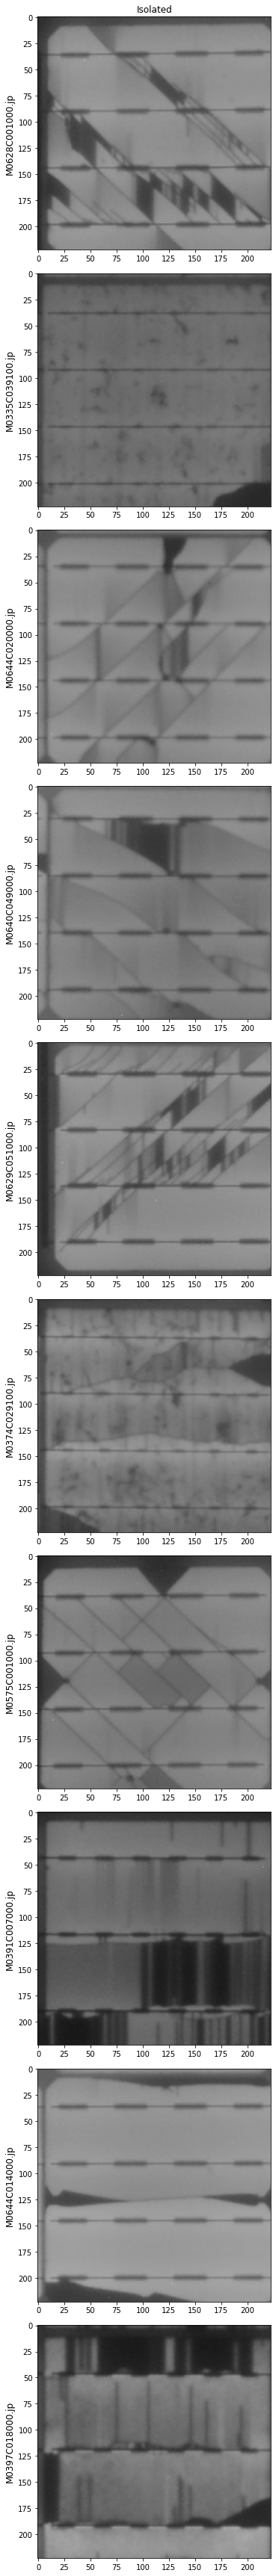

In [5]:
# Load 100 examples and name the category for it. Category is like a title for images
n_samples = 10
isolated = (DefectViewer() << (ImageLoader(defect_class='Isolated') << n_samples))
isolated.category = 'Isolated'
_ = Show(num_images=10, seed=seed) << (isolated)

## EDA 
Isolated Cracks have the following defining features:

- They are darker regions (areas of low luminesence) compared to the rest of the cell, and are often 'dead', which present as black in these images. 
- They are often irregular in shape, but they can be rectangular in shape. 
- They occur typically in the presence of other cracks. 

Potential Approach
- Inverting the image so that the dark regions are brigher regions (not neccesary but just more intuitive when 'subtracting' information we don't want). 
- Thresholding to keep only the brightest (previously darker) regions.
- Potential filtering of vertical lines, so the model doesn't confuse dark vertical fingers
- Potential filtering of horizontal lines, so the model doesn't the busbars. 
- Application of a blob detector to highlight the blobs.
- Erode the background


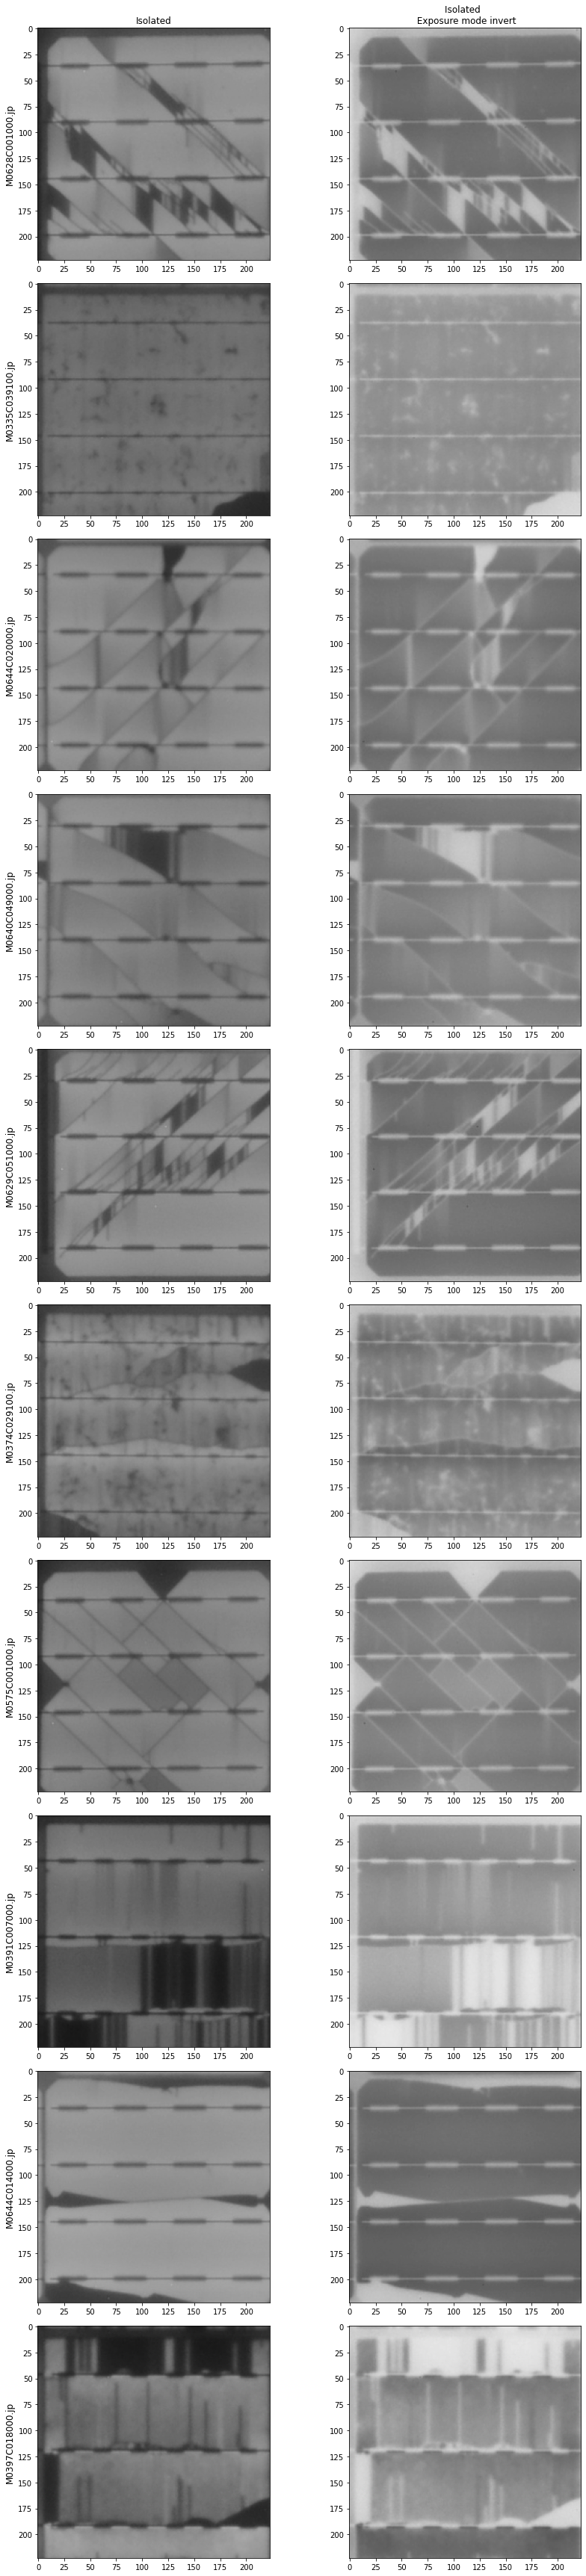

In [6]:
## INVERT IMAGES ## 
# Invert images
original, inverted = Exposure('invert') << isolated
_ = Show(num_images=10, seed=seed) << (original, inverted)

Next we apply thresholding the images using Multi-Otsu thresholding, which is a method of finding threshold boundaries which maximises the inter-bin variances. Because of this, we can apply a local threshold for each image, rather than a global value for all images. This is particularly useful because the incoming images are not normalised/scaled to a global value - a bright region on a bad cell may actually in absolute intensity correspond to a poor region on a good cell. 

In [7]:
## Apply multi-otsu thresholding, we experiment with 2 and 3 thresholds. 
_, thresholded_2 = (Threshold_Multiotsu(2) << (Exposure('invert') << isolated))
_, thresholded_3 = (Threshold_Multiotsu(3) << (Exposure('invert') << isolated))

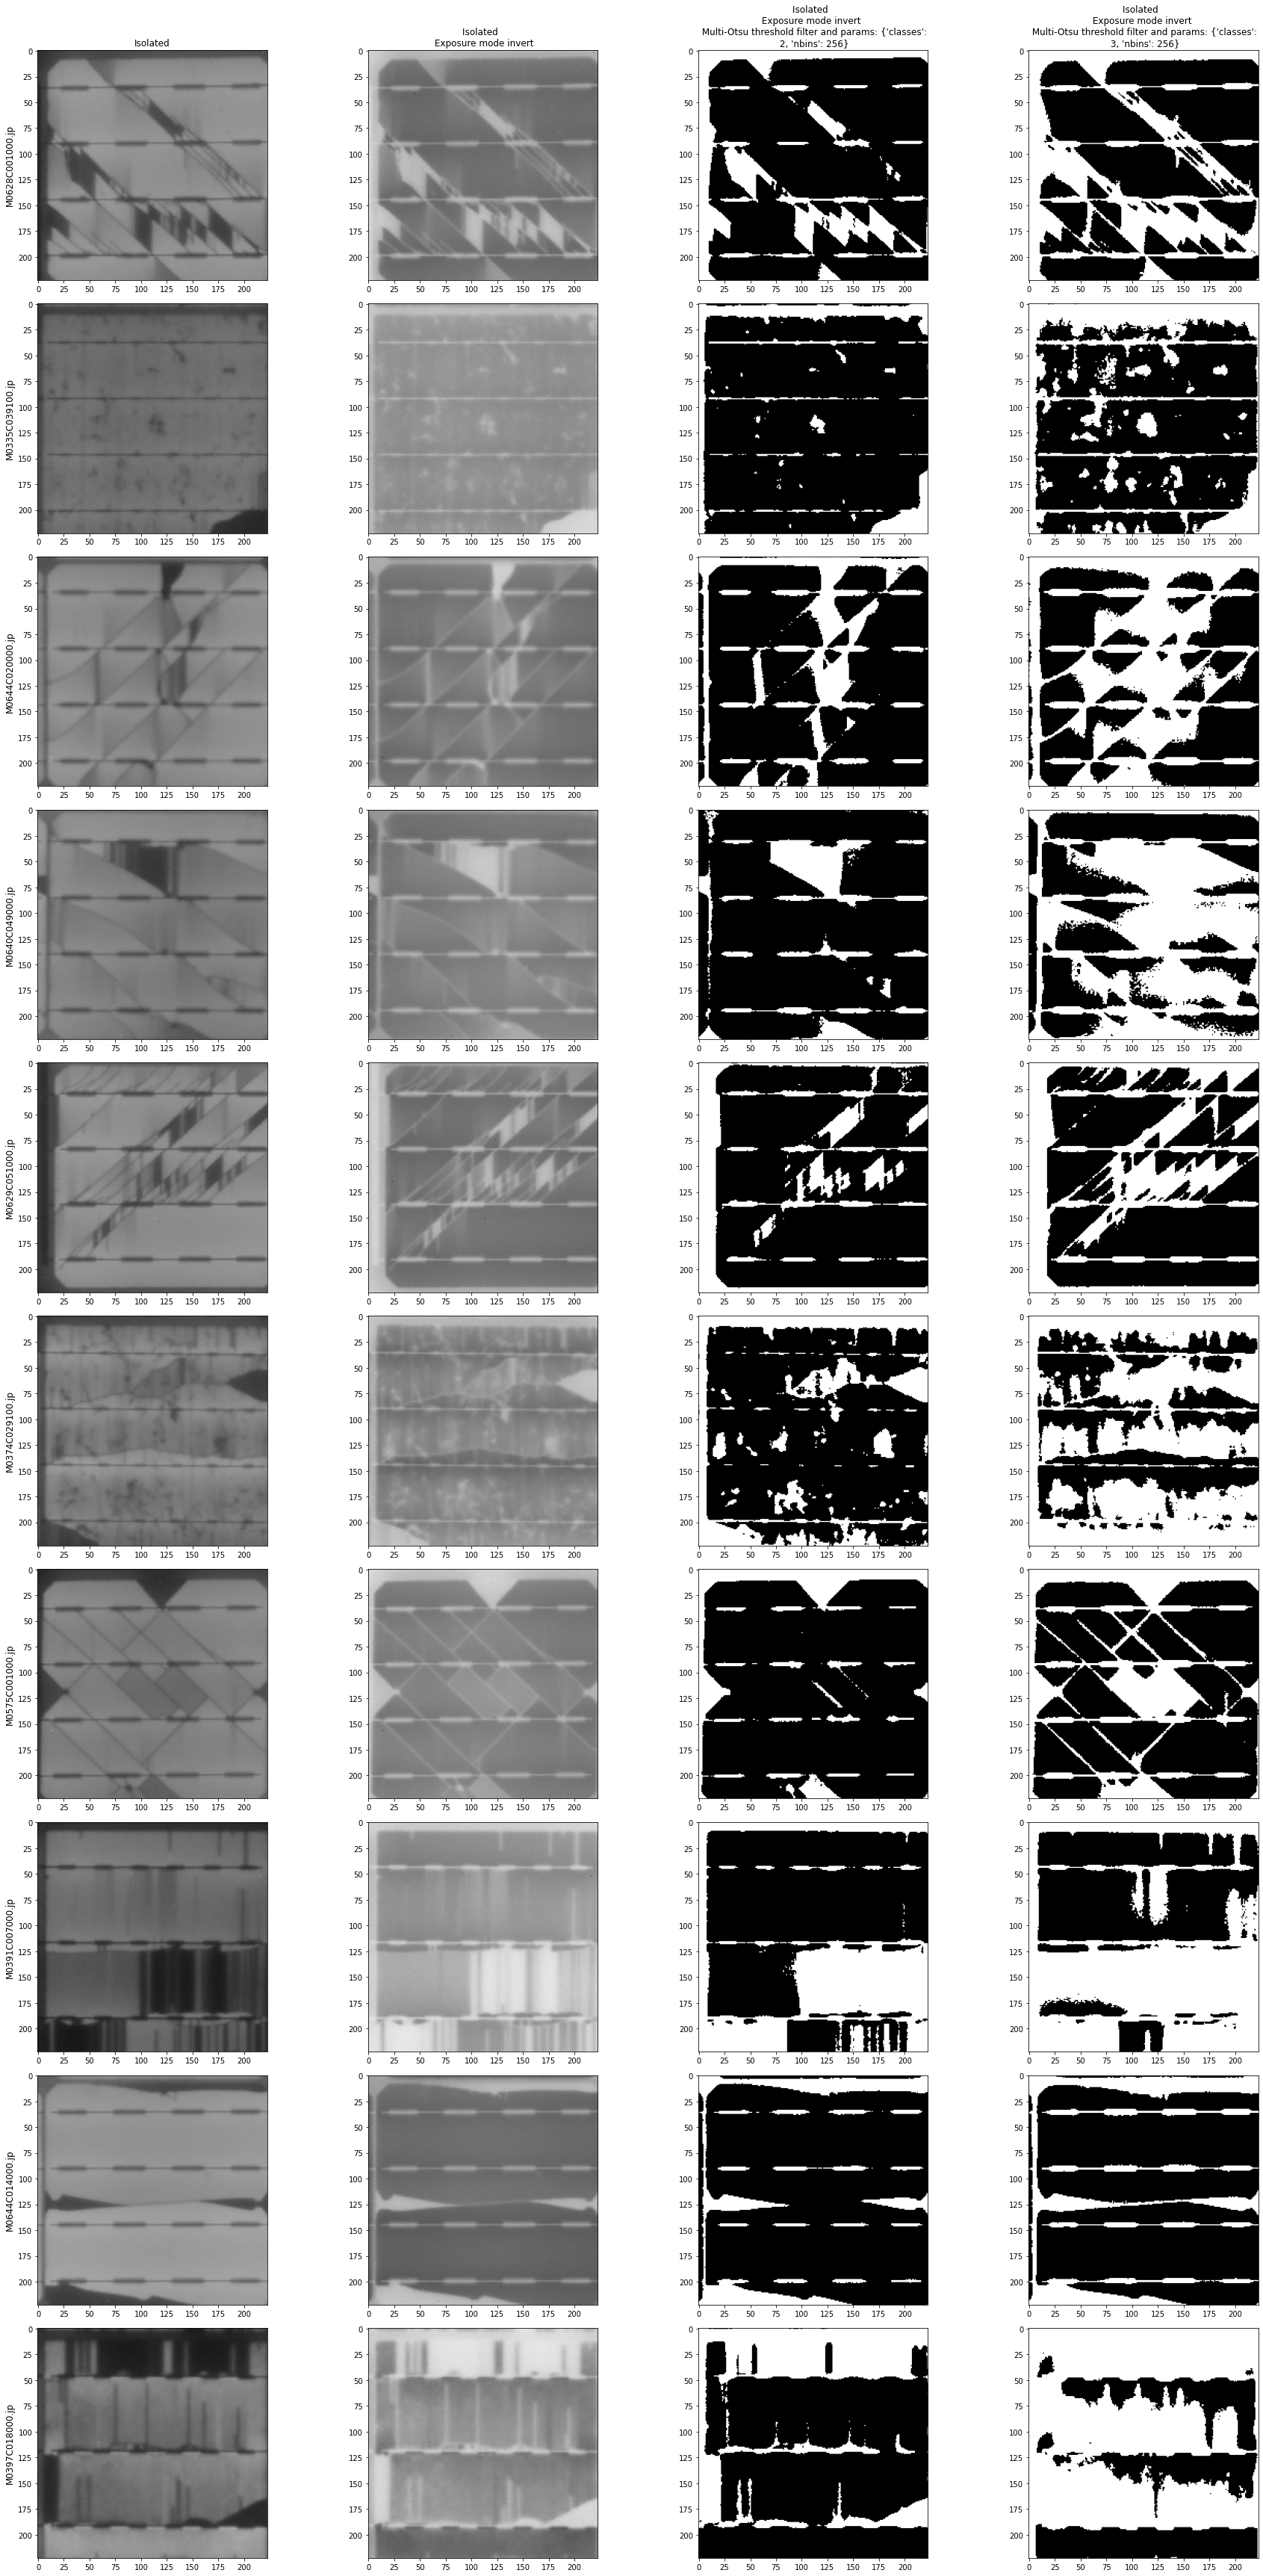

In [8]:
_ = Show(num_images=10, seed=seed) << (original, inverted, thresholded_2, thresholded_3)

This looks pretty reasonable for only two rather simplistic transforms. Having two threshold levels appears to be the right balance between feature vs noise extraction. 

There are a few issues though:

- The busbar pattern is occasionally picked up during the thresholding. 
- Misaligned border crop regions are also picked up during the thresholding.
- Sometimes cracks and thin diagonal and vertical lines are remaining after thresholding. 

The busbar effect can potentially be countered by isolating the thresholded regions of the busbar such that the thresholded pattern corresponding to the busbar is 

The cracks and thin diagonal lines can perhaps be addressed by a combination of:

- Blurring the image with a gaussian kernel may help with avoiding the pick up of unwanted high frequency features such as cracks and thin vertical lines. 
- Band pass filtering to remove high frequency information. 


# Busbar removal

A custom function, BusbarMask was built to detect and remove the busbars via masking. The rough algorithm for this is as follows:
- A Farid horizontal filter is used to extract any horizontal gradients and the returned signal is summed along the rows and squared, so that the negative values of the gradient are now positive.
- A series of filters are applied on the 1D signal, including an edge mask, which ignores any signal within a cerntain number of pixels of the top and bottom edge, since we know there should not be any busbars at the very edges.
- A gaussian blur is then applied to the remaining signal to find the midpoint of the busbar, since each edge of the busbar creates a peak, and we are interested in the centre. THis blur has the effect of creating a maxima in between the two peaks, roughly corresponding to the midpoint. 
- A peak finding algorithm is used to find the peaks, which correspond to the centre of the busbar positions.
- The remaining peaks are then 'broadened' by an input factor to widen the mask. 
- The values are then thresholded to be either 1 or zero and then the mask is lengthened across all columns, to mask out the full row. 
- The resulting mask is then either multiplied by the image or returned as a one-hot encoded matrix. 

An example of this implementation is shown below. In the below, 10 images are shown, and then in the next sequence those same images with the busbar mask/window is then applied. 

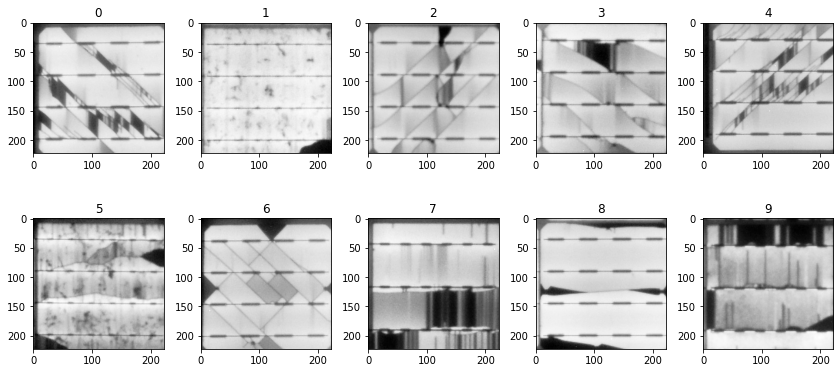

In [9]:
# Original Images
plot_10(isolated.images)

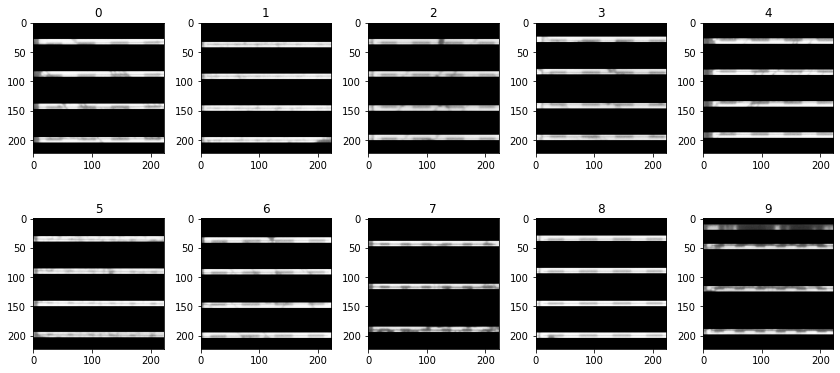

In [10]:
# masked_images
masks = BusbarMask(edge_buffer=15, min_spacing=30, broadening=4).apply(isolated.images)
plot_10(isolated.images * masks)

The algorithm has worked reasonably well, with most images having the correct busbars extracted. A few issues remain however - an edge in image 0 and 9 is confused with a busbar. Thus there is always an issue if the original image crop is poor - sice this means that the edge buffer cannot be set accurately. 

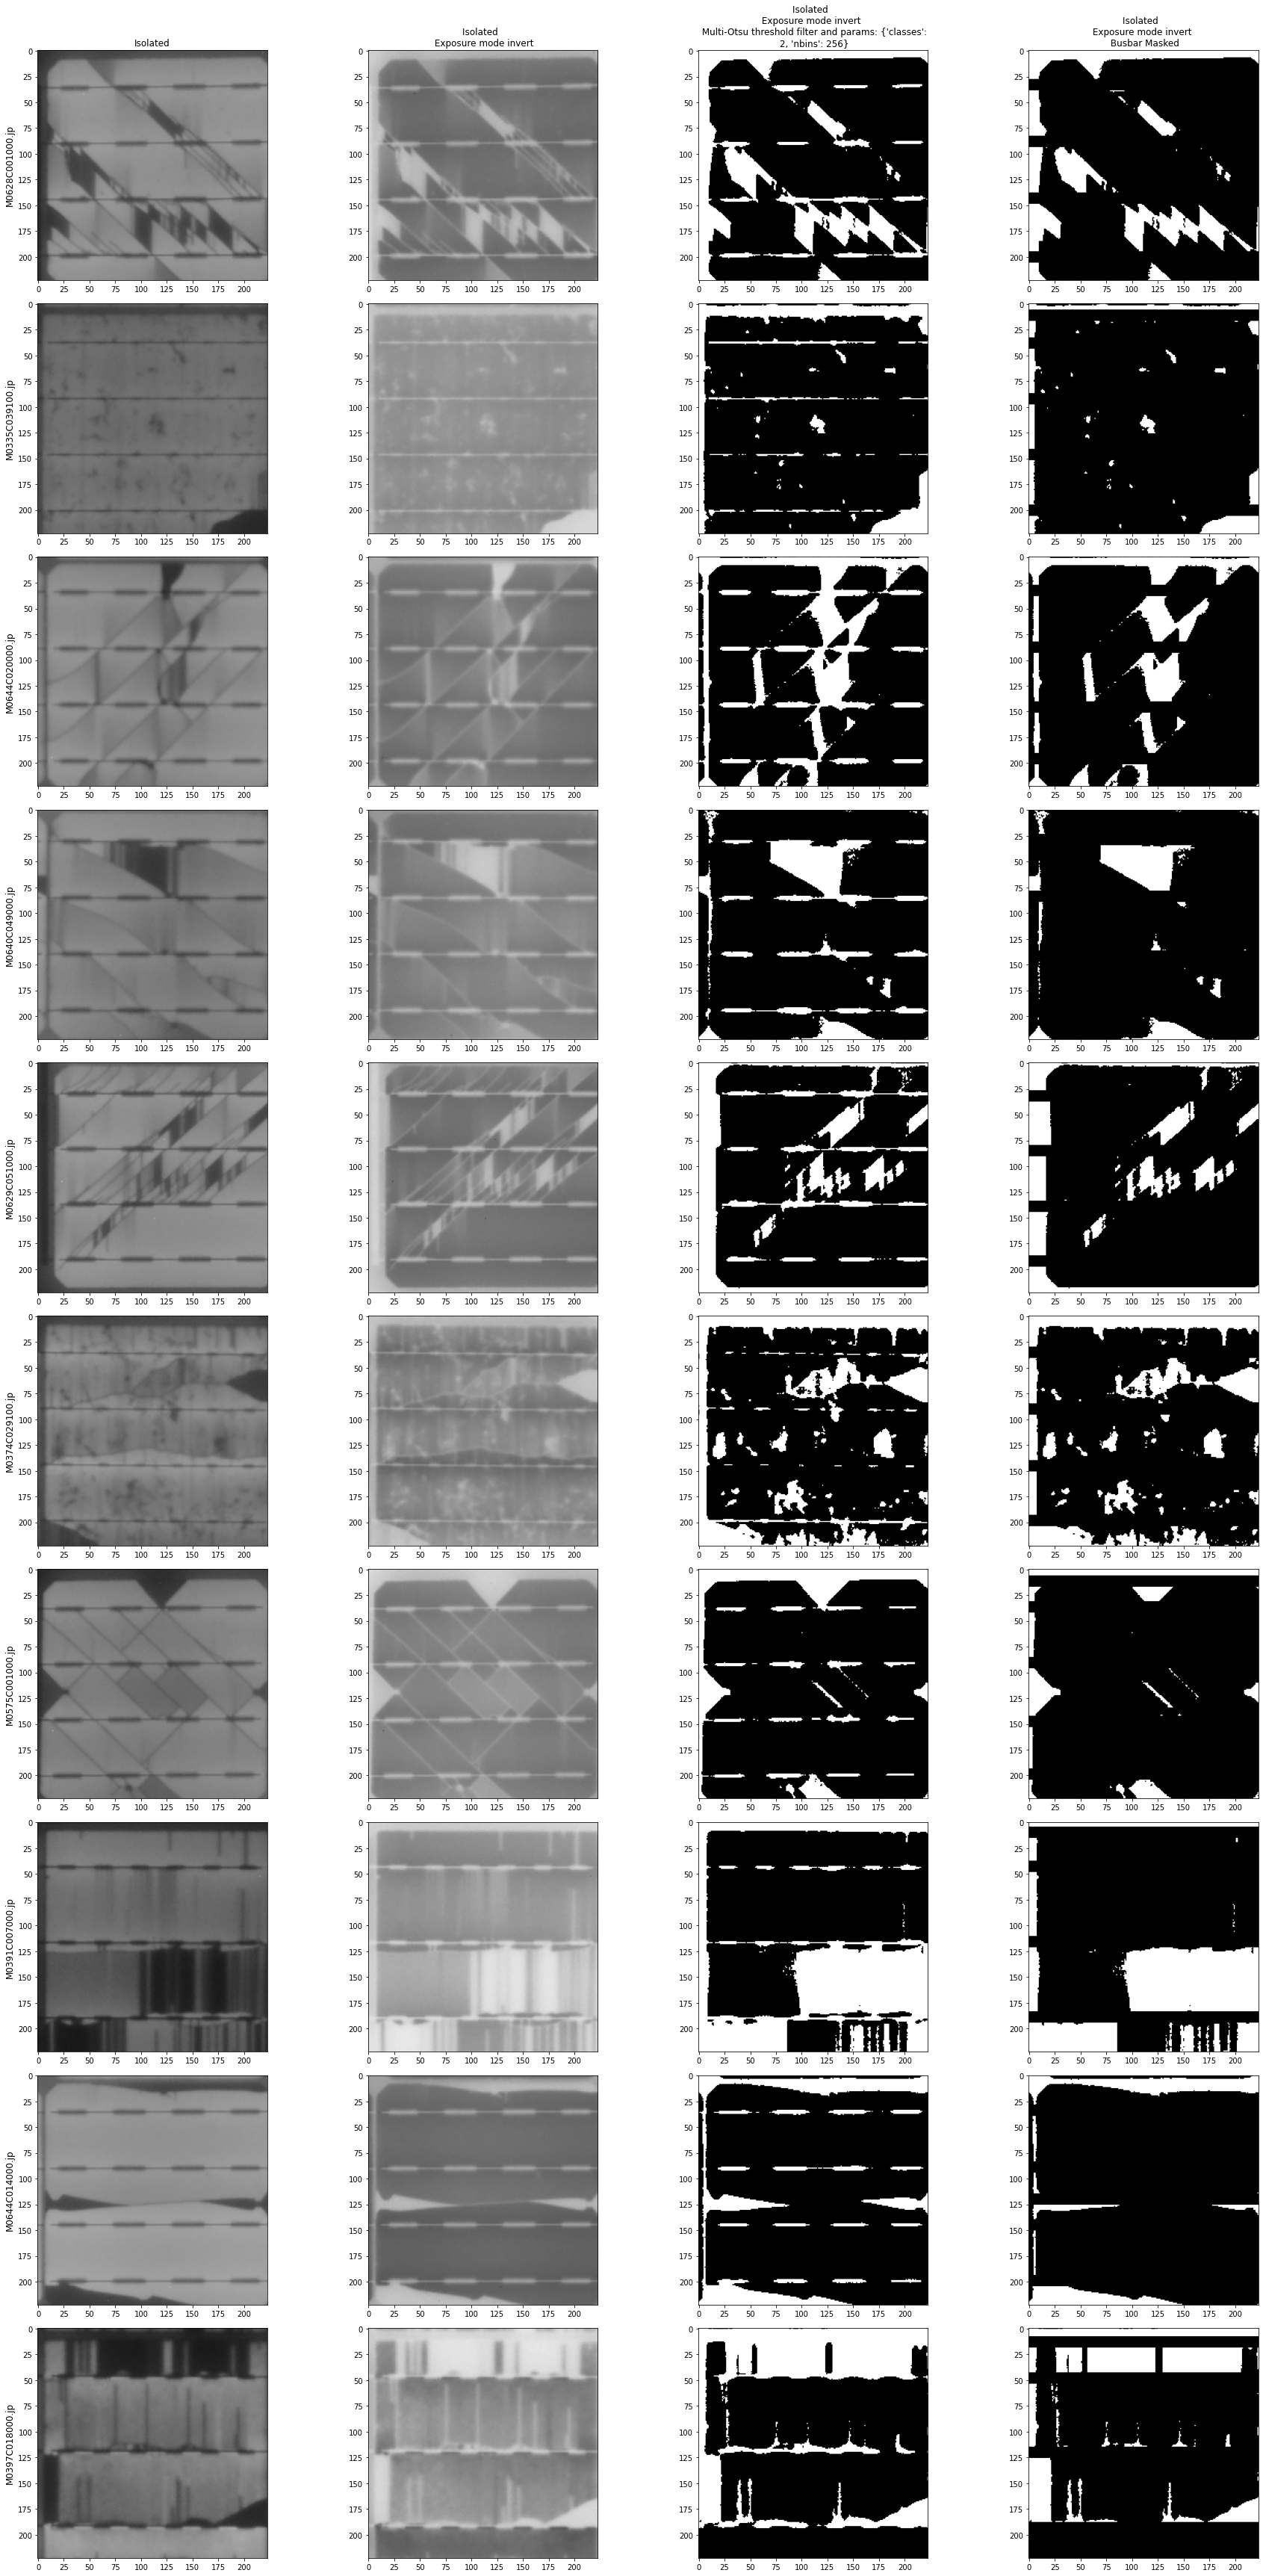

In [11]:
# Busbar removal example in pipeline
# Detect Busbars and remove masks
_ , thresholded_masked = BusbarMask(edge_buffer=10, min_spacing=25, broadening=5) \
        << (Threshold_Multiotsu(2) << (Exposure('invert') << isolated))

_ = Show(num_images=10, seed=seed) << (original, inverted, thresholded_2, thresholded_masked)

## Crack and Line removal

In the thresholded images above, often lines and cracks which are thin are being picked up in the final thresholded image. These are different in that they are thin dark lines, as opposed to thick dark blobs, rather than lines/cracks.

One simple approach may be to downsample and blur the input image, as this will reduce the high frequency information in the image. An example implementation is below

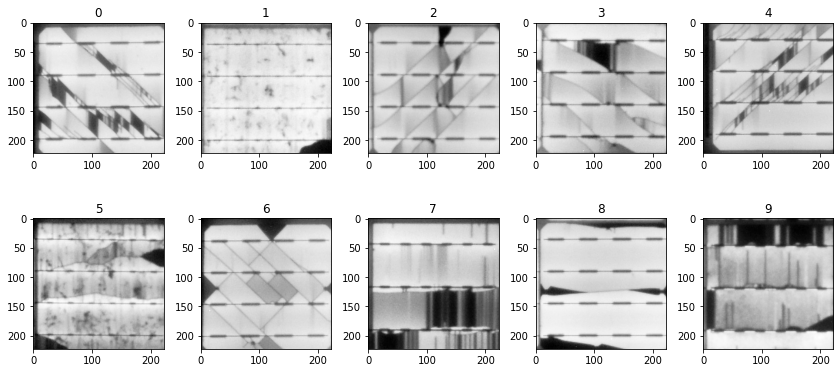

In [12]:
# Original Images
plot_10(isolated.images)

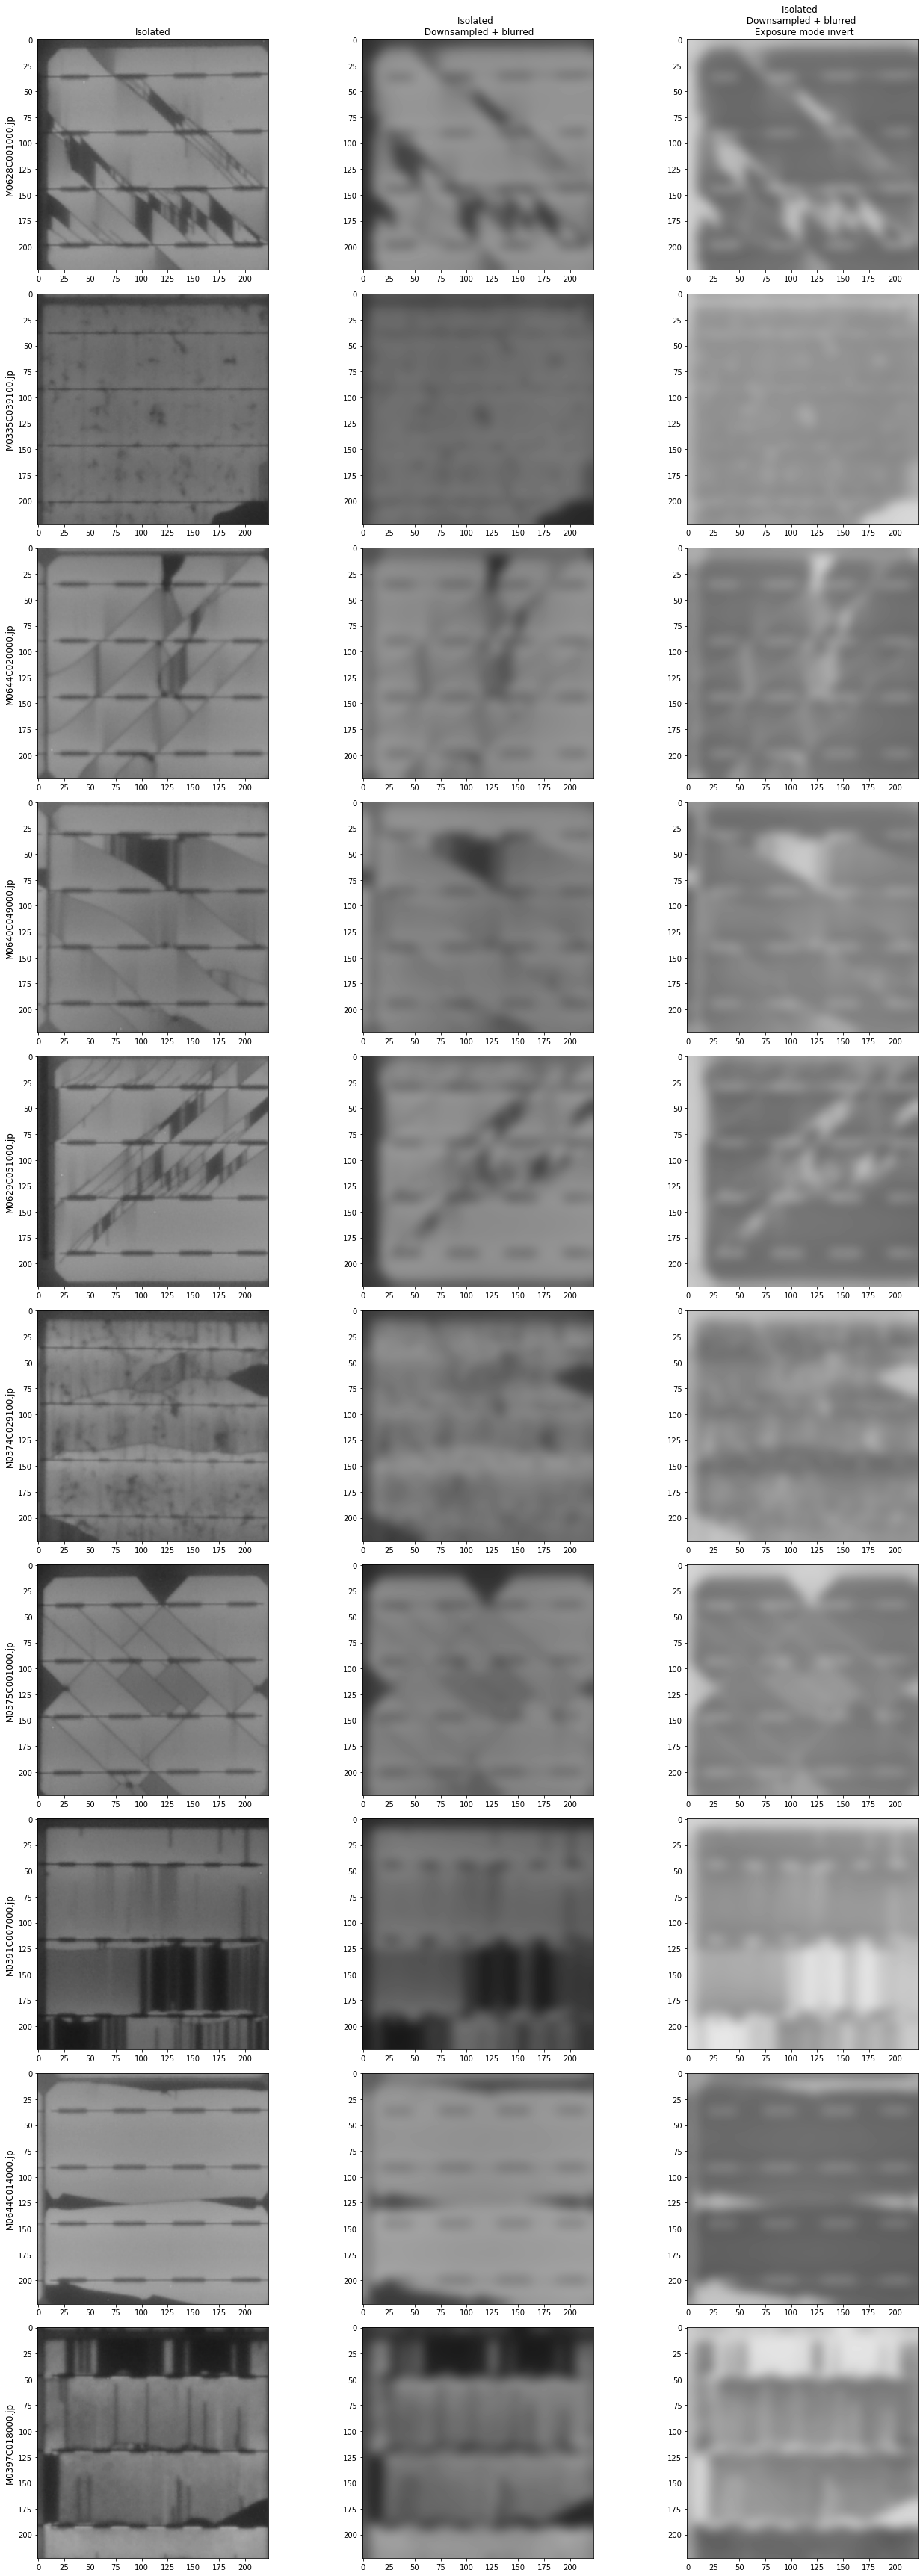

In [16]:
_ , ds_blurred = (DownsampleBlur() << isolated)
_, inverted_blurred = Exposure('invert') << (DownsampleBlur() << isolated)
_ = Show(num_images=10, seed=seed) << (original, ds_blurred, inverted_blurred)

## Start modelling

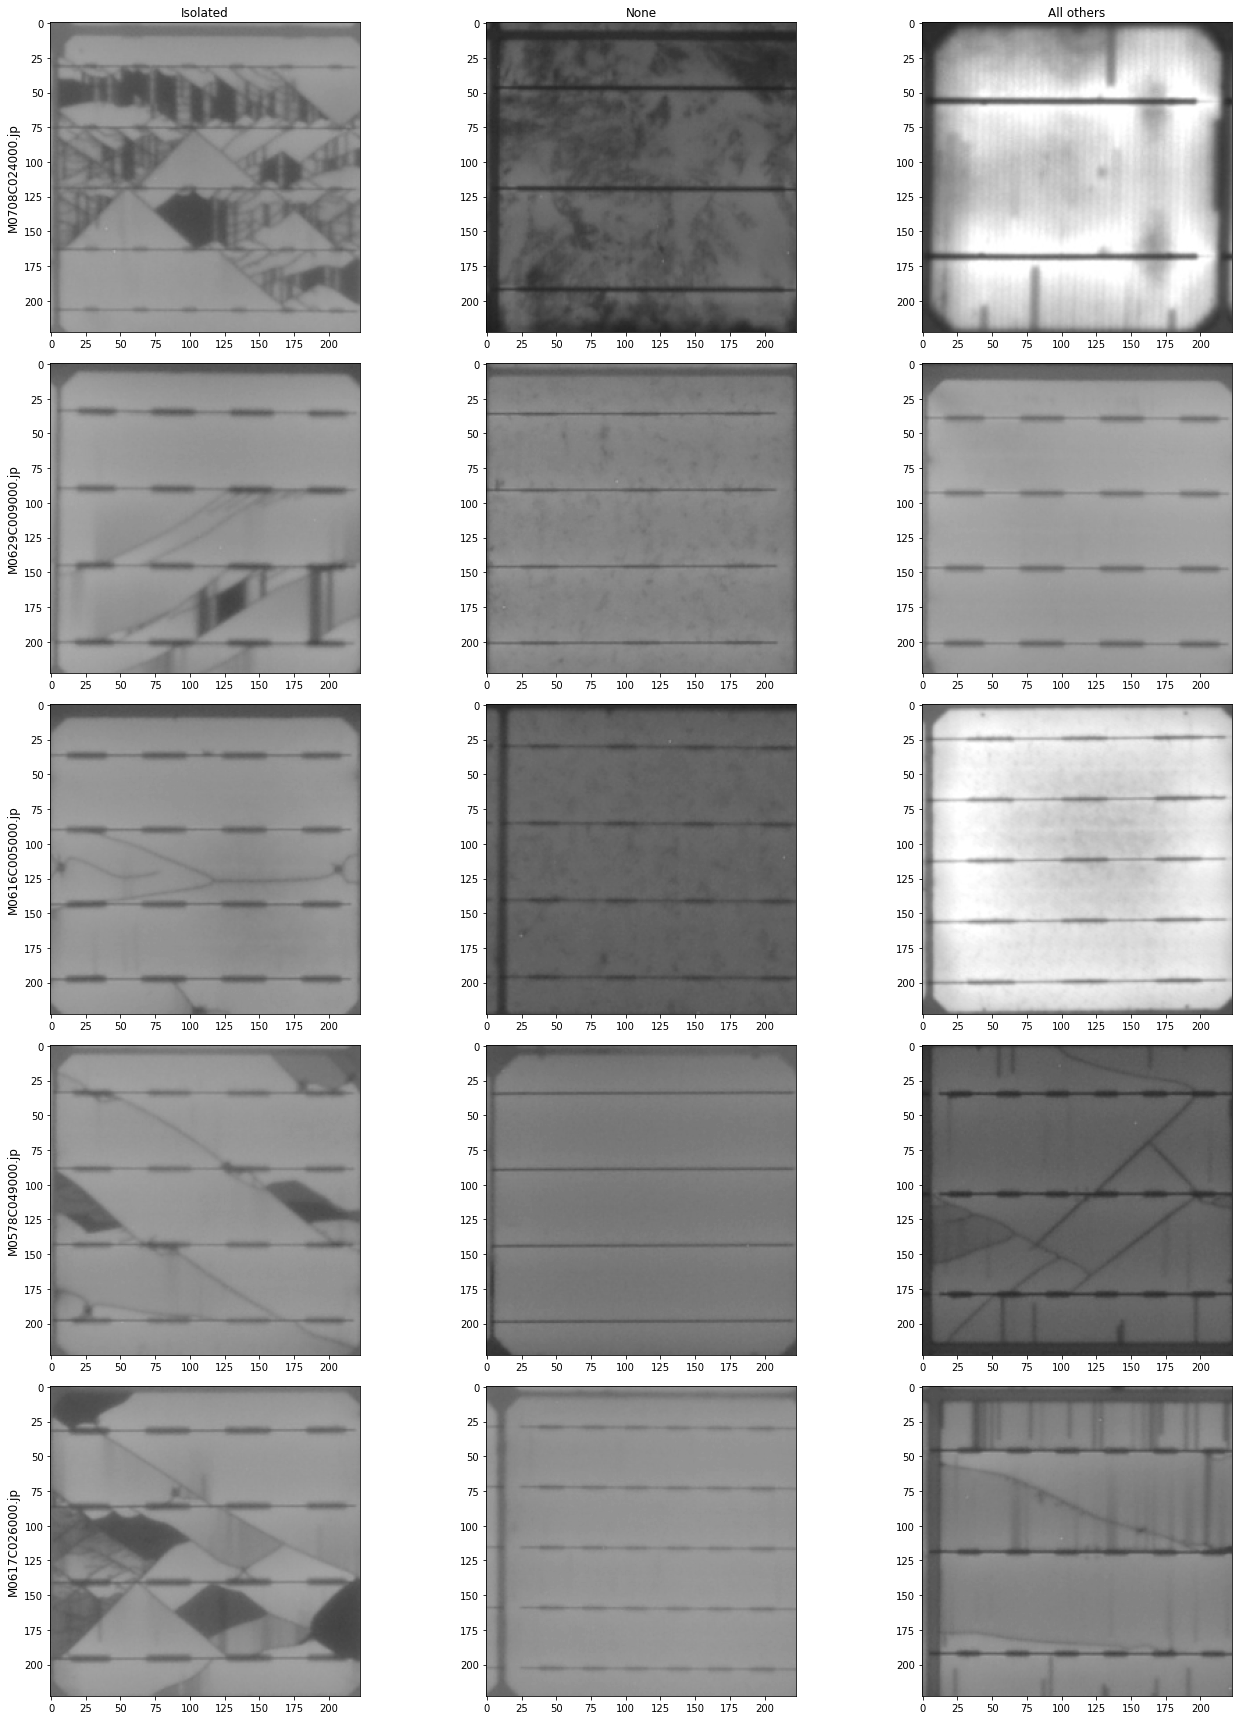

In [93]:
# Get data
n_samples = 1000

defects = (DefectViewer() << (ImageLoader(defect_class='Isolated') << n_samples))
all_others = (DefectViewer() << (ImageLoader(defect_class='Isolated', is_not=True) << n_samples))
clean = (DefectViewer() << (ImageLoader(defect_class='None') << n_samples))

defects.category = 'Isolated'
clean.category = 'None'
all_others.category = 'All others'

_ = Show(num_images=5, seed=2145) << (defects, clean, all_others)

In [94]:
scores = []
titles = []

# Base model on raw data - single defect vs. clean
model_params = {'penalty': 'l2', 'seed': 4156, 'pca_dims': None}
cla = Classifier(defects, clean, LogisticRegression, None)
score = cla.fit(**model_params)
print(score)

scores.append(score)
titles.append('Base model defects vs. clean')

# Misclassified
conf, out = cla.misclassified()
print(tabulate.tabulate([['True 0', conf[0, 0], conf[0, 1]], ['True 1', conf[1, 0], conf[1, 1]]], headers=['', 'Pred 0', 'Pred 1']))

0.8656290661595436
          Pred 0    Pred 1
------  --------  --------
True 0       172        22
True 1        32       174


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [95]:
## Invert and threshold
defects_thresholded = (Threshold_Multiotsu(2) << (Exposure('invert') << defects))
others_thresholded = (Threshold_Multiotsu(2) << (Exposure('invert') << clean))

model_params = {'penalty': 'l2', 'seed': 4156, 'pca_dims': None}
cla = Classifier(defects_thresholded[1], others_thresholded[1], LogisticRegression, None)
score = cla.fit(**model_params)
print(score)

scores.append(score)
titles.append('Base model defects vs. clean + inversion + thresholding')
# Misclassified
conf, out = cla.misclassified()
print(tabulate.tabulate([['True 0', conf[0, 0], conf[0, 1]], ['True 1', conf[1, 0], conf[1, 1]]], headers=['', 'Pred 0', 'Pred 1']))

0.8770143128815935
          Pred 0    Pred 1
------  --------  --------
True 0       167        27
True 1        22       184


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [96]:
## Invert and threshold
defects_blurred_thresholded = (Threshold_Multiotsu(2) << (Exposure('invert') << (DownsampleBlur() << defects)))
others_blurred_thresholded = (Threshold_Multiotsu(2) << (Exposure('invert') << (DownsampleBlur() << clean)))

model_params = {'penalty': 'l2', 'seed': 4156, 'pca_dims': None}
cla = Classifier(defects_blurred_thresholded[1], others_blurred_thresholded[1], LogisticRegression, None)
score = cla.fit(**model_params)
print(score)

scores.append(score)
titles.append('Base model defects vs. clean + inversion + thresholding + blurring')
# Misclassified
conf, out = cla.misclassified()
print(tabulate.tabulate([['True 0', conf[0, 0], conf[0, 1]], ['True 1', conf[1, 0], conf[1, 1]]], headers=['', 'Pred 0', 'Pred 1']))

0.8574467020318286
          Pred 0    Pred 1
------  --------  --------
True 0       166        28
True 1        29       177


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [97]:
## Invert and threshold
defects_blurred_thresholded_no_bb = BusbarMask(edge_buffer=10, min_spacing=25, broadening=5) \
                                << (Threshold_Multiotsu(2) << (Exposure('invert') << (DownsampleBlur() << defects)))
others_blurred_thresholded_no_bb = BusbarMask(edge_buffer=10, min_spacing=25, broadening=5) \
                                << (Threshold_Multiotsu(2) << (Exposure('invert') << (DownsampleBlur() << clean)))

model_params = {'penalty': 'l2', 'seed': 4156, 'pca_dims': None}
cla = Classifier(defects_blurred_thresholded_no_bb[1], others_blurred_thresholded_no_bb[1], LogisticRegression, None)
score = cla.fit(**model_params)
print(score)

scores.append(score)
titles.append('Base model defects vs. clean + inversion + thresholding + blurring + busbar removal')
# Misclassified
conf, out = cla.misclassified()
print(tabulate.tabulate([['True 0', conf[0, 0], conf[0, 1]], ['True 1', conf[1, 0], conf[1, 1]]], headers=['', 'Pred 0', 'Pred 1']))

0.851991792613352
          Pred 0    Pred 1
------  --------  --------
True 0       162        32
True 1        27       179


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


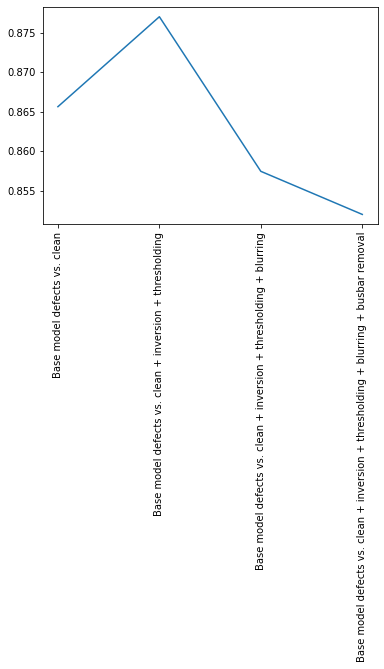

In [98]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(scores))
y = np.array(scores)
plt.xticks(x, titles, rotation=90)
plt.plot(x, y, '-')
plt.show()

In [99]:
scores = []
titles = []

# Base model on raw data - single defect vs. clean
model_params = {'penalty': 'l2', 'seed': 4156, 'pca_dims': None}
cla = Classifier(defects, all_others, LogisticRegression, None)
score = cla.fit(**model_params)
print(score)

scores.append(score)
titles.append('Base model defects vs. all_others')

# Misclassified
conf, out = cla.misclassified()
print(tabulate.tabulate([['True 0', conf[0, 0], conf[0, 1]], ['True 1', conf[1, 0], conf[1, 1]]], headers=['', 'Pred 0', 'Pred 1']))

0.8384796316685017
          Pred 0    Pred 1
------  --------  --------
True 0       169        25
True 1        40       166


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [100]:
## Invert and threshold
defects_thresholded = (Threshold_Multiotsu(2) << (Exposure('invert') << defects))
others_thresholded = (Threshold_Multiotsu(2) << (Exposure('invert') << all_others))

model_params = {'penalty': 'l2', 'seed': 4156, 'pca_dims': None}
cla = Classifier(defects_thresholded[1], others_thresholded[1], LogisticRegression, None)
score = cla.fit(**model_params)
print(score)

scores.append(score)
titles.append('Base model defects vs. all_others + inversion + thresholding')
# Misclassified
conf, out = cla.misclassified()
print(tabulate.tabulate([['True 0', conf[0, 0], conf[0, 1]], ['True 1', conf[1, 0], conf[1, 1]]], headers=['', 'Pred 0', 'Pred 1']))

0.8503152837553798
          Pred 0    Pred 1
------  --------  --------
True 0       167        27
True 1        33       173


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [101]:
## Invert and threshold
defects_blurred_thresholded = (Threshold_Multiotsu(2) << (Exposure('invert') << (DownsampleBlur() << defects)))
others_blurred_thresholded = (Threshold_Multiotsu(2) << (Exposure('invert') << (DownsampleBlur() << all_others)))

model_params = {'penalty': 'l2', 'seed': 4156, 'pca_dims': None}
cla = Classifier(defects_blurred_thresholded[1], others_blurred_thresholded[1], LogisticRegression, None)
score = cla.fit(**model_params)
print(score)

scores.append(score)
titles.append('Base model defects vs. all_others + inversion + thresholding + blurring')
# Misclassified
conf, out = cla.misclassified()
print(tabulate.tabulate([['True 0', conf[0, 0], conf[0, 1]], ['True 1', conf[1, 0], conf[1, 1]]], headers=['', 'Pred 0', 'Pred 1']))

0.8321239115203682
          Pred 0    Pred 1
------  --------  --------
True 0       159        35
True 1        32       174


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [102]:
## Invert and threshold
defects_blurred_thresholded_no_bb = BusbarMask(edge_buffer=10, min_spacing=25, broadening=5) \
                                << (Threshold_Multiotsu(2) << (Exposure('invert') << (DownsampleBlur() << defects)))
others_blurred_thresholded_no_bb = BusbarMask(edge_buffer=10, min_spacing=25, broadening=5) \
                                << (Threshold_Multiotsu(2) << (Exposure('invert') << (DownsampleBlur() << all_others)))

model_params = {'penalty': 'l2', 'seed': 4156, 'pca_dims': None}
cla = Classifier(defects_blurred_thresholded_no_bb[1], others_blurred_thresholded_no_bb[1], LogisticRegression, None)
score = cla.fit(**model_params)
print(score)

scores.append(score)
titles.append('Base model defects vs. all_others + inversion + thresholding + blurring + busbar removal')
# Misclassified
conf, out = cla.misclassified()
print(tabulate.tabulate([['True 0', conf[0, 0], conf[0, 1]], ['True 1', conf[1, 0], conf[1, 1]]], headers=['', 'Pred 0', 'Pred 1']))

0.8345510959863878
          Pred 0    Pred 1
------  --------  --------
True 0       159        35
True 1        31       175


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


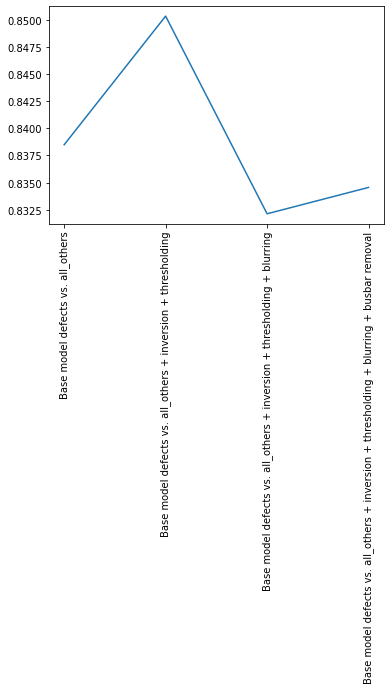

In [103]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(scores))
y = np.array(scores)
plt.xticks(x, titles, rotation=90)
plt.plot(x, y, '-')
plt.show()

In [104]:
from sklearn.ensemble import GradientBoostingClassifier

## Invert and threshold
defects_blurred_thresholded = (Threshold_Multiotsu(2) << (Exposure('invert') << (DownsampleBlur() << defects)))
others_blurred_thresholded = (Threshold_Multiotsu(2) << (Exposure('invert') << (DownsampleBlur() << clean)))

model_params = {'seed': 14376,'n_estimators': 300, 'max_depth': 4, 'learning_rate': 0.1, 'pca_dims': 160}
cla = Classifier(defects_blurred_thresholded[1], others_blurred_thresholded[1], GradientBoostingClassifier, None)
score = cla.fit(**model_params)
print(score)

scores.append(score)
titles.append('Base model all images with defect vs. rest of images')
# Misclassified
conf, out = cla.misclassified()
print(tabulate.tabulate([['True 0', conf[0, 0], conf[0, 1]], ['True 1', conf[1, 0], conf[1, 1]]], headers=['', 'Pred 0', 'Pred 1']))

0.9078245851167681
          Pred 0    Pred 1
------  --------  --------
True 0       186        21
True 1        16       177


In [ ]:
from scipy import ndimage

# function to create Laplacian kernels of a certain size
def LapMask(n):
    mask = np.ones((n,n))
    mask[int(np.ceil(n/2))-1, int(np.ceil(n/2))-1] = 1 - n**2
    return mask

def convolve(in_img, in_kernel):
    return ndimage.convolve(in_img, in_kernel, mode='reflect')

In [ ]:
test_img = original.images[0]

In [ ]:
# create figure
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))
axes = axes.flatten()

for i in range(len(thresholded_2.images)):
    # BEGIN SOLUTION
    # create a laplacian kernel according to the current scale
    kernel = LapMask(3)

    # apply the laplacian filter to the original image
    out_im = convolve(thresholded_masked.images[i], kernel * -1)
    # END SOLUTION

    # plot output image for each scale
    axes[i].imshow(out_im, cmap='gray')
    axes[i].set_title(f'{i}')
    axes[i].axis('off')

plt.show()

In [ ]:
plot_10(original.images)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

from scipy.ndimage import convolve
from scipy import signal

# Display the fft and the image
def display_fft(in_img, title, log=False, fixed_range=False):
    
    # fourier image
    [ydim, xdim] = in_img.shape
    win = np.outer(np.hanning(ydim), np.hanning(xdim))
    win = win/np.mean(win)

    # fourier image
    F = np.fft.fftshift(np.fft.fft2(in_img*win))
    Fmag = np.abs(F)
    Fmag[Fmag < 0.01] = 0.01

    # Display results
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

    # Display image
    if fixed_range:
        axes[0].imshow(in_img, vmin=0, vmax=1, cmap=plt.cm.gray)
    else:
        axes[0].imshow(in_img, cmap=plt.cm.gray)
        axes[0].set_axis_off()
        axes[0].set_title('Input Image')

    if log:
        axes[1].imshow(np.log(Fmag), cmap=plt.cm.gray)
    else:
        axes[1].imshow(Fmag, cmap=plt.cm.gray)
        axes[1].set_axis_off()
        axes[1].set_title('Fourier Magnitude')

    plt.suptitle(f'{title}')
    plt.show()  

# Create a radial mask
def create_mask(in_rad, shape):

    # create circle mask
    in_mask = np.zeros(shape)
    cy = in_mask.shape[0] // 2
    cx = in_mask.shape[1] // 2
    cv2.circle(in_mask, (cx,cy), in_rad, (255, 255, 255), -1)[0]
    in_mask = in_mask / 255

    # blur the mask
    mask2 = cv2.GaussianBlur(in_mask, (15, 15), 10.5, cv2.BORDER_DEFAULT)

    return mask2

# Apply a mask to the FFT image
def mask_fft(in_img, mask):
            
    F = np.fft.fftshift(np.fft.fft2(in_img))
    Fmag = np.abs(F) * mask

    # the ifft assume the incoming fft is shifted to the center of the image
    combined = np.fft.ifftshift(np.multiply(Fmag, np.exp(1j * np.angle(F))))
    imgCombined = np.real(np.fft.ifft2(combined))

    return imgCombined

# Create a Gaussian of a specific size
def create_2d_gaussian(size=9, std=1.5):

    gaussian_1d = signal.gaussian(size, std=std)
    gaussian_2d = np.outer(gaussian_1d, gaussian_1d)
    gaussian_2d = gaussian_2d / (gaussian_2d.sum())

    return gaussian_2d

In [ ]:
# create a mask which is 1 in the center portion 
# with a radius defined in pixels
mask = create_mask(50, test_img.shape)
plt.imshow(mask, cmap='gray')
plt.axis('off')
plt.title('Mask')
plt.show()

# apply the mask to the fft of the image
masked_image = mask_fft(test_img, mask)
display_fft(masked_image, 'Masked Image')

In [ ]:
# Load Einstein image and convert to double
al_img = original.images[6]

display_fft(al_img, 'original image', log=True)

# set Gaussian sigmas and sizes
sigma = [1.5, 2, 3.5]
gsize = [17, 23, 35]

# TODO: Set appropriate FFT mask sizes to match the Gaussian Filters above
ms = [50, 35, 25]

for i in range(len(ms)):

    print('**************************************************************************\n\n')

    # apply mask to FFT of original image
    mask  = create_mask(ms[i], al_img.shape)
    fft_masked_image = mask_fft(al_img, mask)

    # apply blur to original image
    gauss = create_2d_gaussian(size=gsize[i], std=sigma[i])
    blur_img = convolve(al_img, gauss, mode='reflect')

    # compare resulting images and FFTs
    display_fft(fft_masked_image, 'FFT Masked Image', log=True, fixed_range=True)
    display_fft(blur_img, 'Blurred Image', log=True, fixed_range=True)

In [ ]:
from skimage.filters import difference_of_gaussians, window
from scipy.fft import fftn, fftshift

image = original.images[2]
wimage = image * window('hann', image.shape)  # window image to improve FFT
filtered_image = difference_of_gaussians(image, 1)
filtered_wimage = filtered_image * window('hann', image.shape)
im_f_mag = fftshift(np.abs(fftn(wimage)))
fim_f_mag = fftshift(np.abs(fftn(filtered_wimage)))

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
ax[0, 0].imshow(image, cmap='gray')
ax[0, 0].set_title('Original Image')
ax[0, 1].imshow(np.log(im_f_mag), cmap='magma')
ax[0, 1].set_title('Original FFT Magnitude (log)')
ax[1, 0].imshow(filtered_image, cmap='gray')
ax[1, 0].set_title('Filtered Image')
ax[1, 1].imshow(np.log(fim_f_mag), cmap='magma')
ax[1, 1].set_title('Filtered FFT Magnitude (log)')
plt.show()

In [ ]:
plt.imshow(low_pass)

In [ ]:
def plot_comparison(original, filtered, filter_name):

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4), sharex=True,
                                   sharey=True)
    ax1.imshow(original, cmap=plt.cm.gray)
    ax1.set_title('original')
    ax1.axis('off')
    ax2.imshow(filtered, cmap=plt.cm.gray)
    ax2.set_title(filter_name)
    ax2.axis('off')

In [ ]:
from skimage.morphology import (erosion, dilation, opening, closing,  # noqa
                                white_tophat)
from skimage.morphology import black_tophat, skeletonize, convex_hull_image  # noqa
from skimage.morphology import disk  # noqa

test_img = original.images[6]

footprint = disk(3)
eroded = erosion(test_img, footprint)
plot_comparison(test_img, eroded, 'erosion')

In [ ]:
dilated = dilation(test_img, footprint)
plot_comparison(test_img, dilated, 'dilation')

In [ ]:
opened = opening(test_img, footprint)
plot_comparison(test_img, opened, 'opening')